In [126]:
import os
import sys
os.environ["MODEL_DIR"] = '../model'
from pathlib import Path
import pandas as pd
from datasets import load_dataset, Dataset
from tqdm.notebook import tqdm
import nlpaug.augmenter.word as naw
import numpy as np
from simcse import SimCSE
import torch
from matplotlib import pyplot as plt

In [82]:
!ls ../data/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
csv		    wiki1m_for_simcse.txt  wiki_delete_one_word.csv
download_nli.sh     wiki_cropping_0.1.csv  wiki_synonym_replacement.csv
download_wiki.sh    wiki_cropping_0.1.txt  wiki_word_deletion_0.1.csv
nli_for_simcse.csv  wiki_cropping_0.2.csv  wiki_word_deletion_0.2.csv
text		    wiki_cropping_0.3.csv  wiki_word_deletion_0.3.csv


In [112]:
data_folder = Path('../data/').resolve()
data_files = {
    "train": str(data_folder / "wiki1m_for_simcse.txt")
}
extension = "text"

wiki_dataset = load_dataset(extension, data_files=data_files, cache_dir="../data/")

03/05/2023 12:09:19 - WARNING - datasets.builder -   Using custom data configuration default-e985b51e47473734
03/05/2023 12:09:19 - WARNING - datasets.builder -   Found cached dataset text (/home/aksh/SimCSE/cse517wi23_reproducibility_study/../data/text/default-e985b51e47473734/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

In [113]:
aug = naw.SynonymAug(aug_src='wordnet')
rnd = np.random.default_rng(42)


def crop_sentence(sentence, fraction=0.1):
    return sentence[:int((1-fraction)*len(sentence))]

def delete_words(sentence, fraction=0.1):
    words = sentence.split(" ")
    n_words = len(words)
    n_words_to_keep = int((1 - fraction)*len(words))
    ids = sorted(rnd.choice(range(n_words), n_words_to_keep, replace=False))
    return " ".join([words[i] for i in ids])

def delete_one_word(sentence):
    words = sentence.split(" ")
    idx_delete = rnd.integers(len(words))
    del words[idx_delete]
    return ' '.join(words)

def replace_a_word_with_synonym(sentence):
    return aug.augment(sentence)
    
for augmentation, kwargs in [
    ("cropping", {"fraction": 0.1}),
    ("cropping", {"fraction": 0.2}),
    ("cropping", {"fraction": 0.3}),
#     ("word_deletion", {"fraction": 0.1}),
#     ("word_deletion", {"fraction": 0.2}),
#     ("word_deletion", {"fraction": 0.3}),
#     ("delete_one_word", {}),
#     ("synonym_replacement", {})
]:
    sent1 = []
    sent2 = []
    for idx, sentence in enumerate(tqdm(wiki_dataset['train'], desc=f'{augmentation}')):
        if augmentation == "cropping":
            new_sentence = crop_sentence(sentence['text'], **kwargs)
        elif augmentation == "word_deletion":
            new_sentence = delete_words(sentence['text'], **kwargs)
        elif augmentation == "delete_one_word":
            new_sentence = delete_one_word(sentence['text'], **kwargs)
        elif augmentation == "synonym_replacement":
            new_sentence = replace_a_word_with_synonym(sentence['text'], **kwargs)[0]
        else:
            raise NotImplementedError(f"Unknown augmentation: {augmentation}")
        sent1.append(sentence['text'])
        sent2.append(new_sentence)
    new_dataset = Dataset.from_dict({'sent1': sent1, 'sent2': sent2})
    suffix = f'_{kwargs["fraction"]}' if "fraction" in kwargs else ""
    new_dataset.to_csv(data_folder / f'wiki_{augmentation}{suffix}.csv', index=False)

cropping:   0%|          | 0/1000000 [00:00<?, ?it/s]

Creating CSV from Arrow format:   0%|          | 0/1000 [00:00<?, ?ba/s]

cropping:   0%|          | 0/1000000 [00:00<?, ?it/s]

Creating CSV from Arrow format:   0%|          | 0/1000 [00:00<?, ?ba/s]

cropping:   0%|          | 0/1000000 [00:00<?, ?it/s]

Creating CSV from Arrow format:   0%|          | 0/1000 [00:00<?, ?ba/s]

In [121]:
data_folder = Path('../data/').resolve()
data_files = {
    "train": str(data_folder / "wiki_cropping_0.1.csv")
}
extension = "csv"

wiki_dataset = load_dataset(extension, data_files=data_files, cache_dir="../data/")

03/06/2023 09:13:39 - WARNING - datasets.builder -   Using custom data configuration default-9ebaf222e0a0f84f
03/06/2023 09:13:39 - WARNING - datasets.builder -   Found cached dataset csv (/home/aksh/SimCSE/cse517wi23_reproducibility_study/../data/csv/default-9ebaf222e0a0f84f/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

## Alignment and uniformity

In [15]:
from senteval.sts import STSBenchmarkEval

In [68]:
sts_b_path = Path("../SentEval/data/downstream/STS/STSBenchmark/")
sts_b_dataset = STSBenchmarkEval(sts_b_path)
sufficiently_close_sent1 = []
sufficiently_close_sent2 = []
all_sentences_1 = []
all_sentences_2 = []
gs_scores = []
for dataset in ['train', 'dev', 'test']:
    for sent1, sent2, score in zip(*sts_b_dataset.data[dataset]):
        if score > 4:
            sufficiently_close_sent1.append(" ".join(sent1))
            sufficiently_close_sent2.append(" ".join(sent2))
        all_sentences_1.append(" ".join(sent1))
        all_sentences_2.append(" ".join(sent2))
        gs_scores.append(score)

In [69]:
# def aligment(embeddings_1, embeddings_2): 
#     return torch.mean(torch.sum(torch.square(embeddings_1 - embeddings_2), dim=-1)).item()

# def uniformity(embeddings_1, embeddings_2):
#     return torch.log(torch.mean(torch.exp(-2*torch.sum(torch.square(embeddings_1 - embeddings_2), dim=-1)))).item()

def _norm(x, eps=1e-8): 
    xnorm = torch.linalg.norm(x, dim=-1)
    xnorm = torch.max(xnorm, torch.ones_like(xnorm) * eps)
    return x / xnorm.unsqueeze(dim=-1)

# from Wang and Isola (with a bit of modification)
# only consider pairs with gs > 4 (from footnote 3)
def _lalign(x, y, ok, alpha=2):
    return ((_norm(x) - _norm(y)).norm(dim=1).pow(alpha) * ok).sum() / ok.sum()

def _lunif(x, t=2):
    sq_pdist = torch.pdist(_norm(x), p=2).pow(2)
    return sq_pdist.mul(-t).exp().mean().log()

In [60]:
!ls ../result/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
delete_one_word			   wiki_cropping_0.1  wiki_word_deletion_0.1
my-unsup-simcse-bert-base-uncased  wiki_cropping_0.2  wiki_word_deletion_0.2
synonym_replacement		   wiki_cropping_0.3  wiki_word_deletion_0.3


In [145]:
def eval_alignment_uniformity(model_path):
    model = SimCSE(model_path)
    all_embeddings_1 = model.encode(all_sentences_1)
    all_embeddings_2 = model.encode(all_sentences_2)
    
    ok = (torch.Tensor(gs_scores) > 4).int()
    align = _lalign(
        all_embeddings_1, 
        all_embeddings_2, 
        ok).item()

    # consider all sentences (from footnote 3)
    unif = _lunif(torch.vstack([all_embeddings_1, all_embeddings_2])).item()
    return align, unif

results = {}
for name, model_name in [
    ("Unsup. SimCSE", "bert_base"),
    ("Delete One Word", "delete_one_word"),
    ("Synonym Replacement", "synonym_replacement"),
    ("No Dropout", "dropout_0"),
    ("Crop 10%", "wiki_cropping_0.1"),
    ("Crop 20%", "wiki_cropping_0.2"),
    ("Crop 30%", "wiki_cropping_0.3"),
    ("Word Deletion 10%", "wiki_word_deletion_0.1"),
    ("Word Deletion 20%", "wiki_word_deletion_0.2"),
    ("Word Deletion 30%", "wiki_word_deletion_0.3")
]:
    result = []
    if os.path.exists(str(Path("../result") / f"{model_name}_checkpoint_10")):
        for checkpoint in range(10, 101, 10):
            align, unif = eval_alignment_uniformity(str(Path("../result") / f"{model_name}_checkpoint_{checkpoint}"))
            result.append((align, unif))
            print(f'{model_name}_{checkpoint}: align {align}\t\t uniform {unif}')
            
    align, unif = eval_alignment_uniformity(str(Path("../result") / model_name))
    result.append((align, unif))
    results[name] = result

    print(f'{model_name}: align {align}\t\t uniform {unif}')

Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base_checkpoint_10 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:07<00:00, 17.22it/s]


bert_base_10: align 0.30045995116233826		 uniform -1.9341658353805542


Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base_checkpoint_20 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:10<00:00, 12.71it/s]


bert_base_20: align 0.3413792848587036		 uniform -2.2493622303009033


Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base_checkpoint_30 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:38<00:00,  3.55it/s]


bert_base_30: align 0.3608027696609497		 uniform -2.38450026512146


Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base_checkpoint_40 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:53<00:00,  2.52it/s]


bert_base_40: align 0.3743783235549927		 uniform -2.4524154663085938


Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base_checkpoint_50 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:38<00:00,  3.52it/s]


bert_base_50: align 0.38631659746170044		 uniform -2.4857938289642334


Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base_checkpoint_60 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:30<00:00,  4.40it/s]


bert_base_60: align 0.37436553835868835		 uniform -2.405972719192505


Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base_checkpoint_70 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:19<00:00,  6.91it/s]


bert_base_70: align 0.3859829306602478		 uniform -2.4623911380767822


Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base_checkpoint_80 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:18<00:00,  7.44it/s]


bert_base_80: align 0.3866870105266571		 uniform -2.42798113822937


Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base_checkpoint_90 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:17<00:00,  7.55it/s]


bert_base_90: align 0.39572224020957947		 uniform -2.4781219959259033


Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base_checkpoint_100 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.37it/s]


bert_base_100: align 0.40214478969573975		 uniform -2.466568946838379


Some weights of BertModel were not initialized from the model checkpoint at ../result/bert_base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:07<00:00, 16.90it/s]


bert_base: align 0.19737856090068817		 uniform -2.438185691833496


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word_checkpoint_10 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.84it/s]


delete_one_word_10: align 0.2721129357814789		 uniform -1.8869006633758545


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word_checkpoint_20 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.82it/s]


delete_one_word_20: align 0.2717128098011017		 uniform -2.0817840099334717


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word_checkpoint_30 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.82it/s]


delete_one_word_30: align 0.2788313627243042		 uniform -2.2426300048828125


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word_checkpoint_40 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.50it/s]


delete_one_word_40: align 0.2817235589027405		 uniform -2.2661938667297363


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word_checkpoint_50 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.71it/s]


delete_one_word_50: align 0.2781468331813812		 uniform -2.248033285140991


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word_checkpoint_60 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.70it/s]


delete_one_word_60: align 0.2787700593471527		 uniform -2.3176896572113037


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word_checkpoint_70 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.46it/s]


delete_one_word_70: align 0.27193138003349304		 uniform -2.3158934116363525


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word_checkpoint_80 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.83it/s]


delete_one_word_80: align 0.27383291721343994		 uniform -2.341674566268921


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word_checkpoint_90 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.30it/s]


delete_one_word_90: align 0.2731863856315613		 uniform -2.3693246841430664


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word_checkpoint_100 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.72it/s]


delete_one_word_100: align 0.27926188707351685		 uniform -2.4424688816070557


Some weights of BertModel were not initialized from the model checkpoint at ../result/delete_one_word and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.57it/s]


delete_one_word: align 0.21069301664829254		 uniform -2.4002647399902344


Some weights of BertModel were not initialized from the model checkpoint at ../result/synonym_replacement and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.42it/s]


synonym_replacement: align 0.1837439090013504		 uniform -2.0674495697021484


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0_checkpoint_10 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:07<00:00, 16.92it/s]


dropout_0_10: align 0.32398778200149536		 uniform -2.043882131576538


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0_checkpoint_20 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.41it/s]


dropout_0_20: align 0.3414458632469177		 uniform -2.1680679321289062


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0_checkpoint_30 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:07<00:00, 16.90it/s]


dropout_0_30: align 0.3675611615180969		 uniform -2.2935519218444824


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0_checkpoint_40 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.86it/s]


dropout_0_40: align 0.3870692551136017		 uniform -2.41514253616333


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0_checkpoint_50 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.44it/s]


dropout_0_50: align 0.4044138193130493		 uniform -2.480823040008545


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0_checkpoint_60 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.77it/s]


dropout_0_60: align 0.39459657669067383		 uniform -2.4129207134246826


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0_checkpoint_70 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.80it/s]


dropout_0_70: align 0.40107983350753784		 uniform -2.406446933746338


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0_checkpoint_80 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.57it/s]


dropout_0_80: align 0.4073454439640045		 uniform -2.434098482131958


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0_checkpoint_90 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.72it/s]


dropout_0_90: align 0.3900030553340912		 uniform -2.34834361076355


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0_checkpoint_100 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.48it/s]


dropout_0_100: align 0.4016665518283844		 uniform -2.3696937561035156


Some weights of BertModel were not initialized from the model checkpoint at ../result/dropout_0 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.51it/s]


dropout_0: align 0.4212600588798523		 uniform -2.6990084648132324


Some weights of BertModel were not initialized from the model checkpoint at ../result/wiki_cropping_0.1 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.63it/s]


wiki_cropping_0.1: align 0.2649458050727844		 uniform -2.539599895477295


Some weights of BertModel were not initialized from the model checkpoint at ../result/wiki_cropping_0.2 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.77it/s]


wiki_cropping_0.2: align 0.2975025773048401		 uniform -2.570436954498291


Some weights of BertModel were not initialized from the model checkpoint at ../result/wiki_cropping_0.3 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:07<00:00, 16.89it/s]


wiki_cropping_0.3: align 0.2915760278701782		 uniform -2.4595165252685547


Some weights of BertModel were not initialized from the model checkpoint at ../result/wiki_word_deletion_0.1 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.70it/s]


wiki_word_deletion_0.1: align 0.19788984954357147		 uniform -2.3934266567230225


Some weights of BertModel were not initialized from the model checkpoint at ../result/wiki_word_deletion_0.2 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.26it/s]


wiki_word_deletion_0.2: align 0.18668298423290253		 uniform -2.349052906036377


Some weights of BertModel were not initialized from the model checkpoint at ../result/wiki_word_deletion_0.3 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.28it/s]


wiki_word_deletion_0.3: align 0.16986298561096191		 uniform -2.046895980834961


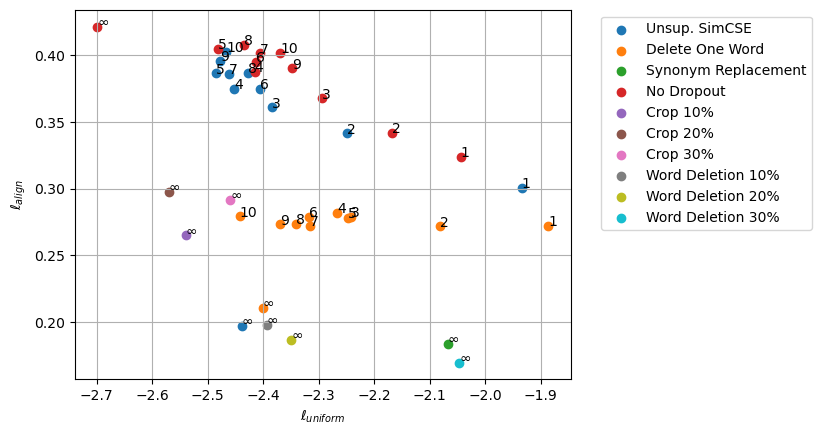

In [147]:
for name, result in results.items():
    alignment = [_[0] for _ in result]
    uniformity = [_[1] for _ in result]
    plt.scatter(uniformity, alignment, label=name)
    for i, (al, un) in enumerate(result[:-1]):
        plt.annotate(i+1, (un, al))
    plt.annotate("∞", (result[-1][1], result[-1][0]))
plt.grid(which='both')
plt.legend(bbox_to_anchor=(1.5, 1))
plt.xlabel(r"$\ell_{uniform}$")
plt.ylabel(r"$\ell_{align}$")
plt.savefig("align_unif_plot.pdf")
plt.show()